# Kagge Sketch-a-Net Inspired CNN Using Stroke Data


In [1]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from random import randint
import pandas as pd
import pickle
import ast
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras.models import load_model

In [2]:
f = open("/data/miniclasses.txt","r")
classes = f.readlines()
f.close()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
n = len(classes)
print('no', n)
vals = [x for x in range(0,n)]
classmap = dict(zip(classes, vals))
classmaprev = dict(zip(vals,classes))

no 340


In [3]:
all_files = glob.glob(os.path.join('shuffledtrain2/', '*.csv'))
batchsize =  530
img_size = 32
N_CLASSES = 340
STEPS = 1000
EPOCHS = 22
size = 32
TEST_DIR = ''
N_FILES = 100

In [4]:
print(all_files)
t = pd.read_csv(all_files[1], nrows = 10)
t['drawing'] = t['drawing'].apply(ast.literal_eval)
labels = t['word']
labels = [c.replace(' ','_') for c in labels]
idx = [classmap[x] for x in labels]
print(idx)

['shuffledtrain2/shuffledtrain2_56.csv', 'shuffledtrain2/shuffledtrain2_41.csv', 'shuffledtrain2/shuffledtrain2_76.csv', 'shuffledtrain2/shuffledtrain2_49.csv', 'shuffledtrain2/shuffledtrain2_99.csv', 'shuffledtrain2/shuffledtrain2_18.csv', 'shuffledtrain2/shuffledtrain2_97.csv', 'shuffledtrain2/shuffledtrain2_9.csv', 'shuffledtrain2/shuffledtrain2_79.csv', 'shuffledtrain2/shuffledtrain2_4.csv', 'shuffledtrain2/shuffledtrain2_27.csv', 'shuffledtrain2/shuffledtrain2_8.csv', 'shuffledtrain2/shuffledtrain2_85.csv', 'shuffledtrain2/shuffledtrain2_93.csv', 'shuffledtrain2/shuffledtrain2_13.csv', 'shuffledtrain2/shuffledtrain2_86.csv', 'shuffledtrain2/shuffledtrain2_100.csv', 'shuffledtrain2/shuffledtrain2_91.csv', 'shuffledtrain2/shuffledtrain2_59.csv', 'shuffledtrain2/shuffledtrain2_24.csv', 'shuffledtrain2/shuffledtrain2_94.csv', 'shuffledtrain2/shuffledtrain2_3.csv', 'shuffledtrain2/shuffledtrain2_10.csv', 'shuffledtrain2/shuffledtrain2_62.csv', 'shuffledtrain2/shuffledtrain2_47.csv', 's

In [5]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def image_generator_xd(all_files,classmap, size, batchsize,ks,N_CLASSES, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = all_files[k]
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                y = np.empty([0])
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                labels = df['word']
                labels = [c.replace(' ','_') for c in labels]
                idx = [classmap[x] for x in labels]
#                 path, _ = filename.split('.csv')
#                 _, classname = path.split('/')
#                 classname = classname.replace(' ','_')
#                 idx = classmap[classname]
#                 labels = np.full(len(df), idx)
                y = np.append(y, idx)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(y, N_CLASSES)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

In [6]:
train_datagen = image_generator_xd(all_files,classmap,size=img_size, N_CLASSES= N_CLASSES,batchsize=batchsize,ks=range(N_FILES))

In [7]:
x, y= next(train_datagen)
print(x.shape)
print(y.shape)

(530, 32, 32, 1)
(530, 340)


(530, 32, 32, 1)
(530, 340)
printing


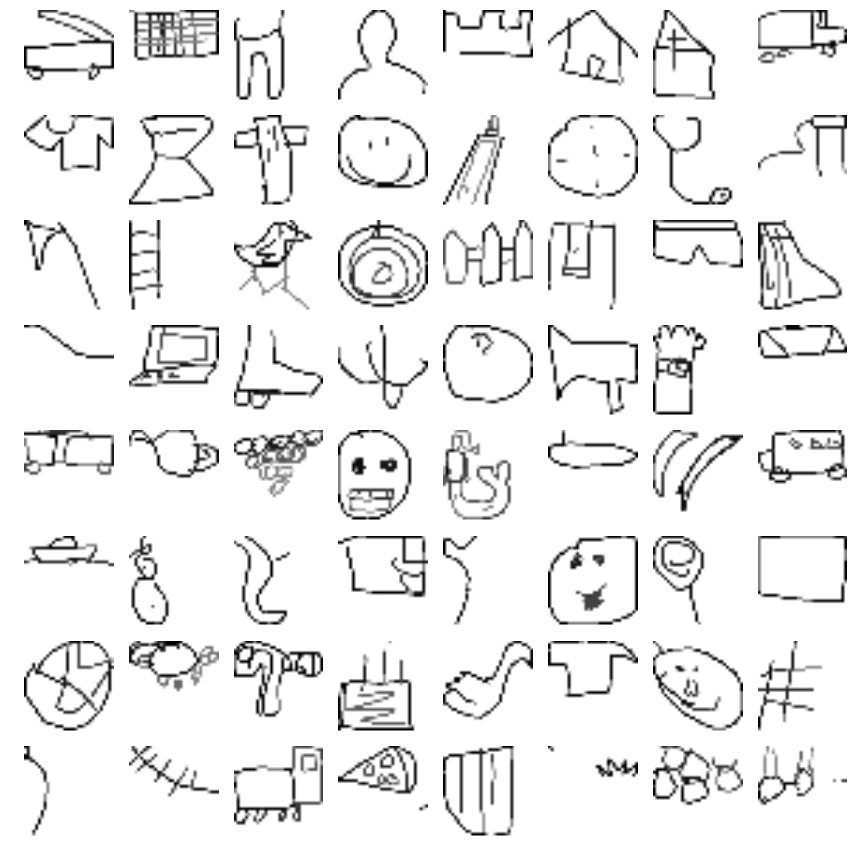

In [8]:
x, y  = next(train_datagen)
print(x.shape)
print(y.shape)
n = 8
print('printing')
%matplotlib inline
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
#fig.savefig('gs.png', dpi=300)
plt.show()
# print(lab)


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Activation, Flatten
model = Sequential()
model.add(Conv2D(128 ,kernel_size=(7,7), activation='relu', input_shape=(size, size, 1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(256, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(340, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(680, kernel_size=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(340, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 128)       6400      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 256)         819456    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 340)         783700    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 340)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 680)         231880    
__________

In [12]:
from tensorflow.keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
)
hists.append(hist)

Epoch 1/22
1000/1000 [==============================] - 184s 184ms/step - loss: 3.8269 - acc: 0.1969 - top_3_accuracy: 0.3458
Epoch 2/22
1000/1000 [==============================] - 180s 180ms/step - loss: 2.6209 - acc: 0.3891 - top_3_accuracy: 0.5999
Epoch 3/22
   3/1000 [..............................] - ETA: 4:01 - loss: 2.4268 - acc: 0.4327 - top_3_accuracy: 0.6434

/home/caj2163_columbia_edu/.local/lib/python3.5/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157835). Check your callbacks.
  % delta_t_median)


1000/1000 [==============================] - 180s 180ms/step - loss: 2.3230 - acc: 0.4486 - top_3_accuracy: 0.6600
Epoch 4/22
1000/1000 [==============================] - 180s 180ms/step - loss: 2.1621 - acc: 0.4819 - top_3_accuracy: 0.6917
Epoch 5/22
1000/1000 [==============================] - 181s 181ms/step - loss: 2.0557 - acc: 0.5027 - top_3_accuracy: 0.7116
Epoch 6/22
1000/1000 [==============================] - 179s 179ms/step - loss: 1.9693 - acc: 0.5207 - top_3_accuracy: 0.7261
Epoch 7/22
1000/1000 [==============================] - 180s 180ms/step - loss: 1.9037 - acc: 0.5332 - top_3_accuracy: 0.7388
Epoch 8/22
1000/1000 [==============================] - 180s 180ms/step - loss: 1.8485 - acc: 0.5437 - top_3_accuracy: 0.7486
Epoch 9/22
1000/1000 [==============================] - 179s 179ms/step - loss: 1.8017 - acc: 0.5531 - top_3_accuracy: 0.7569
Epoch 10/22
1000/1000 [==============================] - 180s 180ms/step - loss: 1.7616 - acc: 0.5602 - top_3_accuracy: 0.7633
Ep

# Submission

In [13]:
test = pd.read_csv('test_simplified.csv')
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

(112199, 3) (112199, 32, 32, 1)
Test array memory 0.43 GB


In [14]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)
top3 = preds2catids(test_predictions)
top3.head()
top3.shape

112199/112199 [==============================] - 7s 59us/step


(112199, 3)

In [15]:
#cats = list_all_categories()
# id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(classmaprev)
print(top3cats.head())
top3cats.shape

                         a         b         c
0                    radio   snorkel    stereo
1                     belt     piano  trombone
2  The_Great_Wall_of_China    castle     camel
3                 mountain      tent   hexagon
4                 campfire  hedgehog   feather


(112199, 3)

In [16]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_test_Sketch_CNN.csv', index=False)
submission.head()
submission.shape

(112199, 2)